# Research Question Doubly Explanatory

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import bambi as bmb
import arviz as az
from bambi import Prior
import jax
import numpy as np

DATA = '../data/'

In [40]:
df = pd.read_csv(DATA+'df_with_model_predictions1.csv', index_col=0)

,labels
count,26621.000000
mean,3.127644
std,0.733605
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,5.000000


## Clean and prepare data

In [36]:
# Read in data and linguistic features

linguistic_features = pd.read_csv(DATA+'all_essay_w_predictability.csv')[['Filename', 'mean_loss', 'mean_prob', 'mean_entropy']]
linguistic_features.columns = ['filename', 'mean_loss', 'mean_prob', 'mean_entropy']
df_model = df.merge(linguistic_features, how='left', on='filename')
linguistic_features = pd.read_csv(DATA+'ELL Data NLP Analysis.csv')[['Filename', 'COCA_magazine_bi_MI']]
linguistic_features.columns = ['filename', 'COCA_magazine_bi_MI']
df_model = df_model.merge(linguistic_features, how='left', on='filename')
df_model.info()  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             26621 non-null  object 
 1   text                 26621 non-null  object 
 2   labels               26621 non-null  float64
 3   rater                26621 non-null  object 
 4   mean_loss            26621 non-null  float64
 5   mean_prob            26621 non-null  float64
 6   mean_entropy         26621 non-null  float64
 7   COCA_magazine_bi_MI  19035 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.6+ MB


In [37]:
# Normalize features
columns_to_normalize = ['mean_loss', 'mean_prob', 'mean_entropy', 'COCA_magazine_bi_MI']
scaler = StandardScaler()
df_model[columns_to_normalize] = scaler.fit_transform(df_model[columns_to_normalize])

In [39]:
df_model=df_model.dropna()

# Calculate filenames per rater
filenames_per_rater = df_model.groupby('rater')['filename'].nunique()

# Calculate statistics
mean_filenames = filenames_per_rater.mean()
std_filenames = filenames_per_rater.std()
min_filenames = filenames_per_rater.min()
max_filenames = filenames_per_rater.max()

# Print results
print("Filename Count per Rater:")
print(filenames_per_rater)
print("\nStatistics:")
print(f"Mean: {mean_filenames}")
print(f"Standard Deviation: {std_filenames}")
print(f"Minimum: {min_filenames}")
print(f"Maximum: {max_filenames}")
print(df_model.describe())

Filename Count per Rater:
rater
model_1      619
model_10     632
model_2      646
model_3      646
model_4      644
model_5      657
model_6      629
model_7      617
model_8      623
model_9      632
rater_1      577
rater_10     549
rater_11    1090
rater_12     901
rater_13     673
rater_14      22
rater_15     775
rater_16     337
rater_17      78
rater_18     814
rater_19     773
rater_2     1062
rater_20      60
rater_21     283
rater_22     191
rater_23     560
rater_24     175
rater_25      23
rater_26     163
rater_27     326
rater_3      222
rater_4      424
rater_5      129
rater_6      826
rater_7      763
rater_8      295
rater_9      599
Name: filename, dtype: int64

Statistics:
Mean: 514.4594594594595
Standard Deviation: 287.922693578463
Minimum: 22
Maximum: 1090
             labels     mean_loss     mean_prob  mean_entropy  \
count  19035.000000  19035.000000  19035.000000  19035.000000   
mean       3.115997      0.000188     -0.010732     -0.000267   
std        0.69

In [7]:
# Verify each file has exactly 3 ratings
rating_counts = df.groupby('filename').size()
print(f"Files with exactly 3 ratings: {(rating_counts == 3).sum()}")
print(f"Files with != 3 ratings: {(rating_counts != 3).sum()}")

# If all files have exactly 3 ratings, this simple approach works:
def create_three_column_format(df):
    # Create a temporary dataframe with one row per (filename, rater_type)
    temp_df = df.copy()
    
    # Create a consistent ordering: model first, then human raters
    temp_df['sort_key'] = temp_df['rater'].apply(
        lambda x: (0, x) if x.startswith('model') else (1, x)
    )
    temp_df = temp_df.sort_values(['filename', 'sort_key'])

    # Add sequence within each file
    temp_df['seq'] = temp_df.groupby('filename').cumcount()

    # Pivot
    pivot_df = temp_df.pivot(
        index=['filename', 'text'],
        columns='seq',
        values='labels'
    ).reset_index()
    
    # Rename columns
    pivot_df.columns = ['filename', 'text', 'model', 'rater_a', 'rater_b']
    
    return pivot_df

result_df = create_three_column_format(df_model).dropna()
result_df

Files with exactly 3 ratings: 8867
Files with != 3 ratings: 10


,filename,text,model,rater_a,rater_b
0,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",3.0,3.0,3.0
1,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",3.0,2.0,3.0
2,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,3.0,3.0,3.0
3,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,3.0,3.0,3.0
4,2021000705.txt,Do you really think students need cell phones ...,3.0,3.0,3.0
...,...,...,...,...,...
6340,AAAXMP138200002211022133_OR.txt,The decision regarding extracurricular involve...,4.0,4.0,4.0
6341,AAAXMP138200002211062115_OR.txt,"The school plans to change to a new, healthier...",3.0,3.0,3.0
6342,AAAXMP138200002211752151_OR.txt,I raised by my grandparents and they always to...,4.0,4.0,4.0
6343,AAAXMP138200002214212144_OR.txt,Imagine the world if students didn't complete ...,3.0,4.0,4.0


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your transformed dataframe with columns:
# ['filename', 'text', 'rater_a', 'rater_b', 'model']

# Convert ratings to integers (if they're floats)
df_clean = result_df.copy()
for col in ['rater_a', 'rater_b', 'model']:
    df_clean[col] = df_clean[col].astype(int)

print(f"Total files: {len(df_clean)}")
print(f"Rating ranges:")
for col in ['rater_a', 'rater_b', 'model']:
    print(f"  {col}: {df_clean[col].min()} to {df_clean[col].max()}")

# Function to calculate Quadratic Weighted Kappa
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate Quadratic Weighted Kappa
    Equivalent to scikit-learn's cohen_kappa_score with weights='quadratic'
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Calculate QWK for each comparison
print("\n=== Quadratic Weighted Kappa Results ===")

# 1. Between the two human raters (inter-rater reliability)
qwk_human = quadratic_weighted_kappa(df_clean['rater_a'], df_clean['rater_b'])
print(f"Human rater A vs Human rater B: {qwk_human:.4f}")

# 2. Between model and each human rater
qwk_model_vs_a = quadratic_weighted_kappa(df_clean['model'], df_clean['rater_a'])
qwk_model_vs_b = quadratic_weighted_kappa(df_clean['model'], df_clean['rater_b'])

print(f"Model vs Human rater A: {qwk_model_vs_a:.4f}")
print(f"Model vs Human rater B: {qwk_model_vs_b:.4f}")

# 3. Model vs human consensus (average of two raters, rounded)
human_consensus = ((df_clean['rater_a'] + df_clean['rater_b']) / 2).round().astype(int)
qwk_model_vs_consensus = quadratic_weighted_kappa(df_clean['model'], human_consensus)
print(f"Model vs Human consensus: {qwk_model_vs_consensus:.4f}")

# 4. Create a comprehensive results dataframe
results = pd.DataFrame({
    'Comparison': [
        'Human A vs Human B',
        'Model vs Human A', 
        'Model vs Human B',
        'Model vs Consensus'
    ],
    'Quadratic_Weighted_Kappa': [
        qwk_human,
        qwk_model_vs_a,
        qwk_model_vs_b,
        qwk_model_vs_consensus
    ],
    'Number_of_Samples': [len(df_clean)] * 4
})

print("\n=== Summary Table ===")
print(results.to_string(index=False))

Total files: 6345
Rating ranges:
  rater_a: 1 to 5
  rater_b: 1 to 5
  model: 2 to 5

=== Quadratic Weighted Kappa Results ===
Human rater A vs Human rater B: 0.5134
Model vs Human rater A: 0.5088
Model vs Human rater B: 0.5217
Model vs Human consensus: 0.5179

=== Summary Table ===
        Comparison  Quadratic_Weighted_Kappa  Number_of_Samples
Human A vs Human B                  0.513405               6345
  Model vs Human A                  0.508844               6345
  Model vs Human B                  0.521668               6345
Model vs Consensus                  0.517913               6345


In [9]:
df_model[['COCA_magazine_bi_MI', 'mean_prob']].corr()

,COCA_magazine_bi_MI,mean_prob
COCA_magazine_bi_MI,1.000000,0.467105
mean_prob,0.467105,1.000000


In [41]:
df_model['rater_type'] = df_model['rater'].str.split('_').str[0]

df_model['labels_ordinal'] = pd.Categorical(
    df_model['labels'], 
    categories=sorted(df_model['labels'].unique()), 
    ordered=True
)

In [43]:
df_model[df_model['rater_type']=='rater']

,filename,text,labels,rater,mean_loss,mean_prob,mean_entropy,COCA_magazine_bi_MI,rater_type,labels_ordinal
8878,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",3.0,rater_1,-0.120529,0.069122,-0.376462,-0.353352,rater,3.0
8879,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",2.0,rater_1,-0.662951,0.570721,-0.575862,-0.329550,rater,2.0
8880,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,3.0,rater_1,0.058501,-0.570535,0.087132,0.339846,rater,3.0
8881,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,3.0,rater_1,-0.760763,0.738523,-0.651040,0.147232,rater,3.0
8882,2021000705.txt,Do you really think students need cell phones ...,3.0,rater_1,0.162345,-0.184256,0.133768,0.220687,rater,3.0
...,...,...,...,...,...,...,...,...,...,...
26614,AAAUUP138190002270872136_OR.txt,Summer is the time for students to take a brea...,5.0,rater_23,-0.964331,0.779522,-0.654862,0.610337,rater,5.0
26616,AAAUUP138190002317322139_OR.txt,We have to work to survive. Employers give us ...,4.0,rater_23,0.116774,-0.165041,0.224358,0.401224,rater,4.0
26618,AAAUUP138190002420682110_OR.txt,Introduction:\r\n\r\nAuthor Ralph Waldo Emerso...,3.0,rater_23,1.069533,-1.262016,1.082492,-0.117417,rater,3.0
26619,AAAUUP138190002783782122_OR.txt,"Technology, has been discuess by many knowledg...",2.0,rater_23,1.426946,-1.050890,0.976796,-0.532473,rater,2.0


## Specify the model

In [12]:
# Specify weakly informative priors to stabilize the model
priors = {
    # Common effects (fixed effects) - main terms and interactions
    'common': Prior("Normal", mu=0, sigma=1),
    
    # Group-specific effects (random effects) need HYPERPRIORS
    '1|Filename': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=1)),
    '1|Rater': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=1)),
    # You can also set specific priors for individual terms if needed
    'mean_prob': Prior("Normal", mu=0, sigma=0.5),
    'COCA_magazine_bi_MI': Prior("Normal", mu=0, sigma=0.5)
}

# Specificy the model
model = bmb.Model(
    formula="labels_ordinal ~ mean_prob + rater_type + COCA_magazine_bi_MI + "
            "mean_prob:rater_type + COCA_magazine_bi_MI:rater_type + "
            "(1 | filename) + (1 | rater)",
    data=df_model,
    family="cumulative",  # For ordinal outcomes
    priors=priors
)

# Fit the model
rq3_results = model.fit(
    draws=2000,
    tune=1000,
    chains=4,
    target_accept=0.95,  # Similar to adapt_delta
    inference_method="numpyro"
)

/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 3000/3000 [02:51<00:00, 17.52it/s, 127 steps of size 3.15e-02. acc. prob=0.97]


In [18]:
# Specify weakly informative priors to stabilize the model
priors = {
    # Common effects (fixed effects) - main terms and interactions
    'common': Prior("Normal", mu=0, sigma=1),
    
    # Group-specific effects (random effects) need HYPERPRIORS
    '1|Filename': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=1)),
    '1|Rater': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=1)),
    # You can also set specific priors for individual terms if needed
    'mean_prob': Prior("Normal", mu=0, sigma=0.5)
}

# Specificy the model
model = bmb.Model(
    formula="labels_ordinal ~ mean_prob + rater_type + "
            "mean_prob:rater_type + "
            "(1 | filename) + (1 | rater)",
    data=df_model,
    family="cumulative",  # For ordinal outcomes
    priors=priors
)

# Fit the model
rq3_results = model.fit(
    draws=2000,
    tune=1000,
    chains=4,
    target_accept=0.95,  # Similar to adapt_delta
    inference_method="numpyro"
)

/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
/home/jovyan/conda_envs/wesenv/lib/python3.13/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 3000/3000 [02:39<00:00, 18.77it/s, 127 steps of size 3.22e-02. acc. prob=0.96]


In [19]:
summary = az.summary(rq3_results)

## Check convergence statistics

In [20]:
def check_convergence(summary, idata):
    """Check convergence statistics"""
    print("=== CONVERGENCE DIAGNOSTICS ===")
    
    # R-hat diagnostics
    rhat_values = summary['r_hat'].values
    print(f"R-hat statistics:")
    print(f"  Min: {np.min(rhat_values):.3f}")
    print(f"  Max: {np.max(rhat_values):.3f}")
    print(f"  Mean: {np.mean(rhat_values):.3f}")
    print(f"  >1.01: {np.sum(rhat_values > 1.01)} parameters")
    print(f"  >1.05: {np.sum(rhat_values > 1.05)} parameters")
    
    # Effective sample size diagnostics
    ess_values = summary['ess_bulk'].values
    print(f"\nEffective Sample Size (ESS):")
    print(f"  Min: {np.min(ess_values):.0f}")
    print(f"  Max: {np.max(ess_values):.0f}")
    print(f"  Mean: {np.mean(ess_values):.0f}")
    print(f"  <400: {np.sum(ess_values < 400)} parameters")
    print(f"  <100: {np.sum(ess_values < 100)} parameters")
    
    # Monte Carlo Standard Error
    mcse_values = summary['mcse_mean'].values
    print(f"\nMonte Carlo Standard Error:")
    print(f"  Min: {np.min(mcse_values):.4f}")
    print(f"  Max: {np.max(mcse_values):.4f}")
    print(f"  Mean: {np.mean(mcse_values):.4f}")
    
    # Check for divergent transitions (if available)
    if hasattr(idata, 'sample_stats') and hasattr(idata.sample_stats, 'diverging'):
        n_divergences = idata.sample_stats.diverging.sum().values
        print(f"\nDivergent transitions: {n_divergences}")
        if n_divergences > 0:
            print("⚠️  WARNING: Divergent transitions detected - model may not have converged properly")

check_convergence(summary, rq3_results)

=== CONVERGENCE DIAGNOSTICS ===
R-hat statistics:
  Min: 1.000
  Max: 1.000
  Mean: 1.000
  >1.01: 0 parameters
  >1.05: 0 parameters

Effective Sample Size (ESS):
  Min: 871
  Max: 20357
  Mean: 14766
  <400: 0 parameters
  <100: 0 parameters

Monte Carlo Standard Error:
  Min: 0.0000
  Max: 0.0120
  Mean: 0.0086

Divergent transitions: 0


## Examine the results
High interaction effects indicate that specific raters are more sensitive to linguistic features.

In [21]:
# Extract just the interaction terms (differential sensitivity)
interaction_terms = [col for col in summary.index if 'rater_type' in col]
diff_sensitivity_results = summary.loc[interaction_terms]
    
print("\n=== DIFFERENTIAL SENSITIVITY RESULTS ===")
diff_sensitivity_results.sort_values('mean', key=abs, ascending=False).head(20)


=== DIFFERENTIAL SENSITIVITY RESULTS ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rater_type[rater],0.216,0.287,-0.312,0.782,0.01,0.005,871.0,1685.0,1.0
mean_prob:rater_type[rater],0.023,0.038,-0.050,0.095,0.00,0.000,11572.0,6147.0,1.0


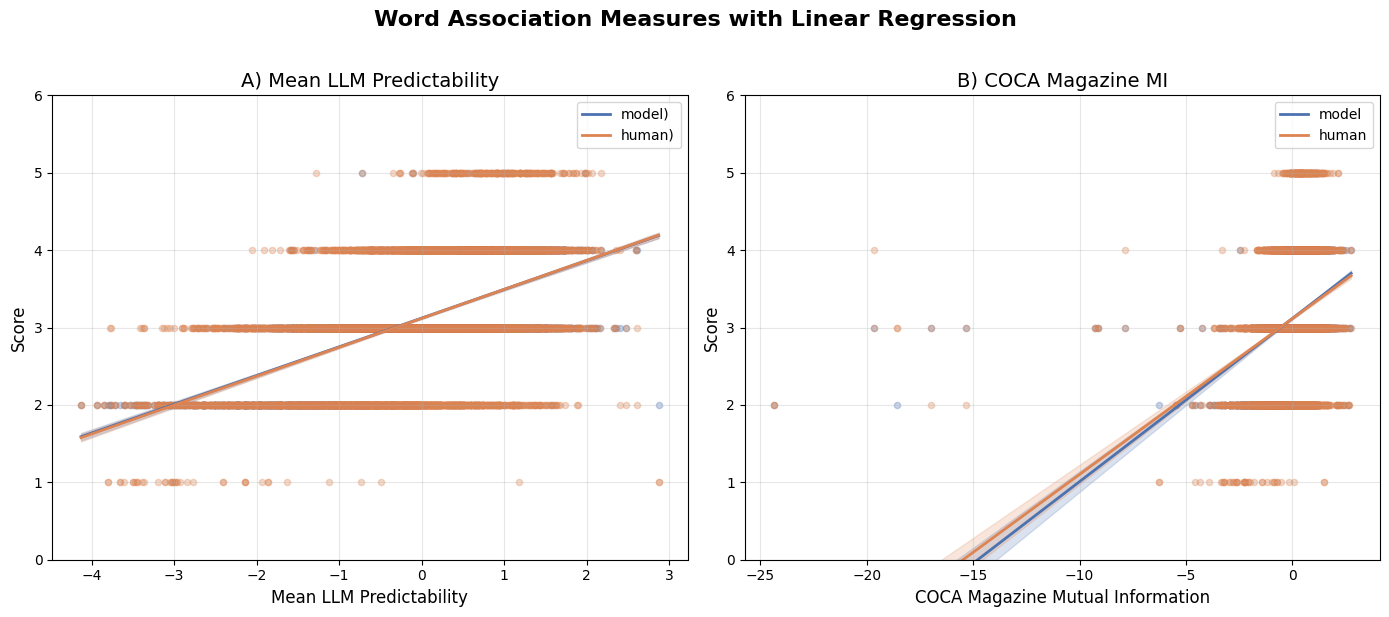

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

def statistical_two_panel_plot(df):
    """Two-panel plot with regression statistics"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    rater_types = df['rater_type'].unique()
    colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']
    
    # Panel 1: Mean Probability with regression
    ax1 = axes[0]
    
    for i, rater in enumerate(rater_types):
        rater_data = df[df['rater_type'] == rater].dropna()
        
        if len(rater_data) < 2:
            continue
            
        # Scatter plot
        ax1.scatter(rater_data['mean_prob'], 
                   rater_data['labels_ordinal'],
                   color=colors[i % len(colors)], 
                   alpha=0.3,
                   s=20)
        
        # Linear regression with confidence interval
        X = sm.add_constant(rater_data['mean_prob'])
        y = rater_data['labels_ordinal']
        model = sm.OLS(y, X).fit()
        
        # Get predictions
        x_range = np.linspace(rater_data['mean_prob'].min(), 
                             rater_data['mean_prob'].max(), 100)
        X_pred = sm.add_constant(x_range)
        y_pred = model.predict(X_pred)
        
        # Confidence interval
        predictions = model.get_prediction(X_pred)
        y_pred_ci = predictions.conf_int(alpha=0.05)
        
        # Replace 'rater' with 'human' in legend label
        legend_label = rater.replace('rater', 'human')
        ax1.plot(x_range, y_pred, 
                color=colors[i % len(colors)], 
                linewidth=2,
                label=f'{legend_label})')
        
        # Plot confidence interval
        ax1.fill_between(x_range, 
                        y_pred_ci[:, 0], 
                        y_pred_ci[:, 1], 
                        color=colors[i % len(colors)], 
                        alpha=0.2)
    
    ax1.set_xlabel('Mean LLM Predictability', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('A) Mean LLM Predictability', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 6)
    
    # Panel 2: COCA Magazine BI MI with regression
    ax2 = axes[1]
    
    for i, rater in enumerate(rater_types):
        rater_data = df[df['rater_type'] == rater].dropna()
        
        if len(rater_data) < 2:
            continue
            
        # Scatter plot
        ax2.scatter(rater_data['COCA_magazine_bi_MI'], 
                   rater_data['labels_ordinal'],
                   color=colors[i % len(colors)], 
                   alpha=0.3,
                   s=20)
        
        # Linear regression
        X = sm.add_constant(rater_data['COCA_magazine_bi_MI'])
        y = rater_data['labels_ordinal']
        model = sm.OLS(y, X).fit()
        
        # Get predictions
        x_range = np.linspace(rater_data['COCA_magazine_bi_MI'].min(), 
                             rater_data['COCA_magazine_bi_MI'].max(), 100)
        X_pred = sm.add_constant(x_range)
        y_pred = model.predict(X_pred)
        
        # Confidence interval
        predictions = model.get_prediction(X_pred)
        y_pred_ci = predictions.conf_int(alpha=0.05)
        
        # Replace 'rater' with 'human' in legend label
        legend_label = rater.replace('rater', 'human')
        ax2.plot(x_range, y_pred, 
                color=colors[i % len(colors)], 
                linewidth=2,
                label=f'{legend_label}')
        
        # Plot confidence interval
        ax2.fill_between(x_range, 
                        y_pred_ci[:, 0], 
                        y_pred_ci[:, 1], 
                        color=colors[i % len(colors)], 
                        alpha=0.2)
    
    ax2.set_xlabel('COCA Magazine Mutual Information', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('B) COCA Magazine MI', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 6)
    
    plt.suptitle('Word Association Measures with Linear Regression', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Create statistical plot
statistical_two_panel_plot(df_model)

In [17]:
summary.to_csv('../results/stat_summary_no_MI.csv')